In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')


In [2]:
DATA_PATH = './data'

In [3]:
# train_x = pd.read_csv(DATA_PATH  + "/train_x_df.csv")
# train_y = pd.read_csv(DATA_PATH  + "/train_y_df.csv")
test_x = pd.read_csv(DATA_PATH  + "/test_x_df.csv")


In [4]:
# vwap과, open에서 vwap을 뺀 값인 diff를 계산합니다.
def make_vwap_and_diff(df):

    
    # 1) VAWP 계산

    # 일반적인 VWAP 공식에서 volume을 그대로 사용하지만, 여러번의 시도를 통해 tb_base_av 와 volume을 더했을 때 가장 좋은 volume이 나온다고 판단하여서 사용하였습니다.
    df["volume_tb_base_av"] = df["tb_base_av"] + df["volume"]

    # volume price
    '''
        시즌2 2위팀 방식 : open하나만을 사용하기 보다는 open(시가), high(고가), low(저가) 3개의 평균을 price로 사용
        code) df['volume_price'] = ((df['open'] + df['high'] + df['low']) / 3) * df['volume_tb_base_av']
    
        1차 수정 방식 :   (open + close)/2 = price 로 사용, 이유는 high와 low를 포함하는 값은 오차의 범위가 너무 커짐
        code) df['volume_price'] = ((df['open'] + df['close']) / 2) * df['volume_tb_base_av']
        
        2차 수정 방식 :   high + low /2를 추가 가격 데이터로 잡아 변동성을 반영하게 바꿈(매수 횟수를 늘리기 위해)
        code) df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']
    '''

    df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']

    # price와 volume의 곱의 합을 구해줍니다.
    df['volume_price_sum'] = df.groupby(['sample_id'])['volume_price'].apply(lambda x: x.cumsum())

    # volume의 합을 구해줍니다.
    df['volume_sum'] = df.groupby(['sample_id'])['volume_tb_base_av'].apply(lambda x: x.cumsum())

    # 2 변수의 나눗셈을 통해 vwap을 계산해줍니다.
    df['vwap'] = df['volume_price_sum'] / df['volume_sum']


    # 2) diff 계산
    # 매도수익이 open을 통해 이루어진다고 알려져있기 때문에 open에서 vwap을 뺀 값을 diff로 사용했습니다.
    df["diff"] = df["open"] - df["vwap"]


    return df


def calcBb(df, w=20, k=2):
    '''
    볼린저밴드를 구하는 공식에 20일 단순이동평균값을 이용할 때,
    close(종가)에 대한 20일 단순이동평균값을 이용하여 계산하는 방식과
    (close + high + low)/3 (종가, 고가,저가의 평균값)에 대한 20일 단순이동평균값을 이용하여 계산하는 방식이 존재합니다.

    그냥 일단 open 데이터로 함
    '''
    x = df['open']
    mean = x.rolling(w, min_periods=1).mean()
    std = x.rolling(w, min_periods=1).std()
    
    df['mildde_ballin'] = mean
    df['upper_ballin'] = mean + (k * std)
    df['lower_ballin'] = mean - (k * std)
    df['ballin_width'] = (2 * k * std) / mean
    
    return df
#     df.round({f'MBB{suffix}': 2, f'UBB{suffix}': 2, f'LBB{suffix}': 2})

In [5]:
# 데이터 프레임에서 sample_id 에 따른 open을 반환하는 함수입니다.
def get_open(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['open'].values
    

In [6]:
# 데이터 프레임에서 sample_id 에 따른 VWAP을 반환하는 함수입니다.
def get_vwap(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['vwap'].values
    

In [7]:
# 데이터 프레임에서 sample_id 에 따른 diff 반환하는 함수입니다.
def get_diff(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['diff'].values
    

In [8]:
# 데이터 프레임에서 sample_id 에 따른 rsi 반환하는 함수입니다.
def get_rsi(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['rsi'].values
    

In [9]:
# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_series(df,sample_id, col_name):
    
    return df[df["sample_id"] == sample_id][col_name].values
    

In [10]:
# RSI를 만들어줍니다.
# 상승분, 하락분의 평균은 일반적으로 14일을 기준으로 생성합니다.
'''
    일반적인 RSI 방식 : 상승분, 하락분의 평균은 일반적으로 14일을 기준으로 생성
    
    1차 수정 방식 :     상승분, 하락분의 평균을 14일 기준으로 하지 않고, 25일기준으로 하여 안정성 향상

    2차 수정 방식 :     9일 기준으로 변동성 더 취해서, 매수 횟수를 늘림 (3일 이내와 같이 너무 단기간은 오히려 별로임)
'''
def make_rsi(df, period = 9):

    # 전일 대비 상승분을 계산해줍니다. - 상승분이 0보다 크면 상승분을 넣고, 0보다 작거나 같으면 0을 넣어줍니다.
    df["U"] = np.where(df.groupby(["sample_id"])["open"].diff(1) > 0, df.groupby(["sample_id"])["open"].diff(1), 0)

    # 전일 대비 하락분을 계산해줍니다. - 하락분이 0보다 작으면 하락분 * -1을 넣고, 0보다 크거나 같으면 0을 넣어줍니다.
    df["D"] = np.where(df.groupby(["sample_id"])["open"].diff(1) < 0, df.groupby(["sample_id"])["open"].diff(1) *(-1), 0)


    # 전일 대비 상승분의 평균을 계산해줍니다.
    ud_df = pd.DataFrame()
    ud_df["sample_id"] = df["sample_id"]
    ud_df["U"] = df["U"]
    ud_df["D"] = df["D"]

    # 상승분의 14일 평균을 구해줍니다.
    df["AU"] = ud_df.groupby(["sample_id"])["U"].rolling( window=period, min_periods=period ).mean().reset_index()["U"]
    # 하락분의 14일 평균을 구해줍니다.
    df["AD"] = ud_df.groupby(["sample_id"])["D"].rolling( window=period, min_periods=period ).mean().reset_index()["D"]


    # AU / (AU + AD) 의 백분율을 RSI 로 계산해줍니다.
    RSI = df["AU"] / (df["AU"] + df["AD"]) * 100
    
    df["rsi"] = RSI
    
    return df
    

In [11]:
# 1. train, test의 sample_id 목록을 저장합니다.
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()


In [12]:
# 2. VWAP, diff 를 만들어줍니다.
test_x = make_vwap_and_diff(test_x)

In [13]:
# 3. rsi 를 만들어줍니다.
test_x = make_rsi(test_x, 25)

In [14]:
# 4. Ballinger Bands 를 만들어줍니다.
temp_data = test_x.groupby(['sample_id']).apply(lambda x: calcBb(x, 20, 2))

In [15]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.grid'] = True

In [16]:
temp_df = temp_data[temp_data['sample_id'] == 7954]

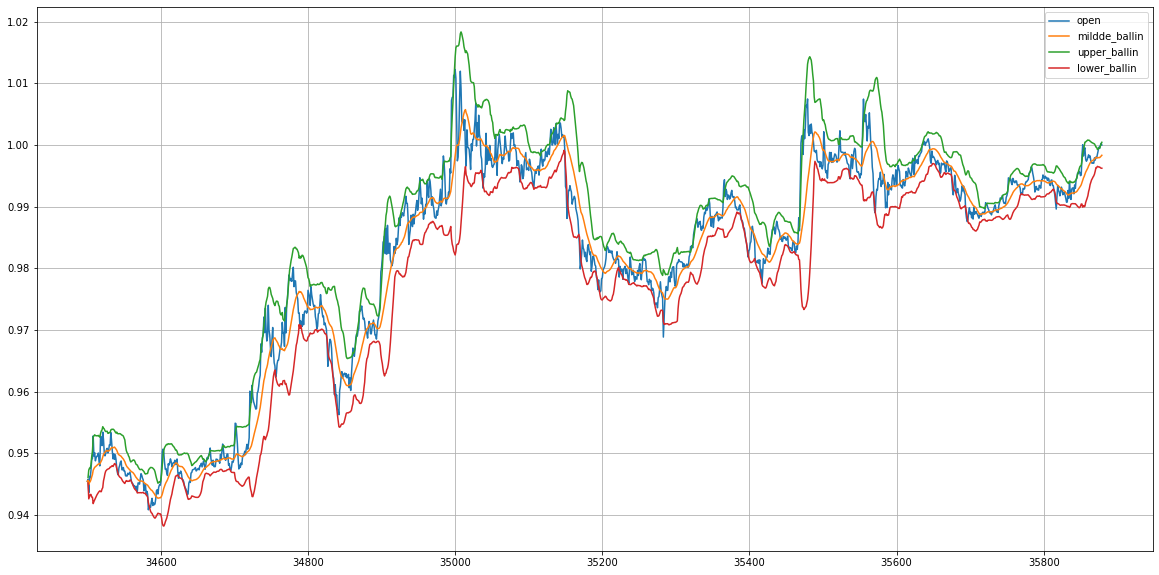

In [17]:
ax1 = temp_df[['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')
plt.show()

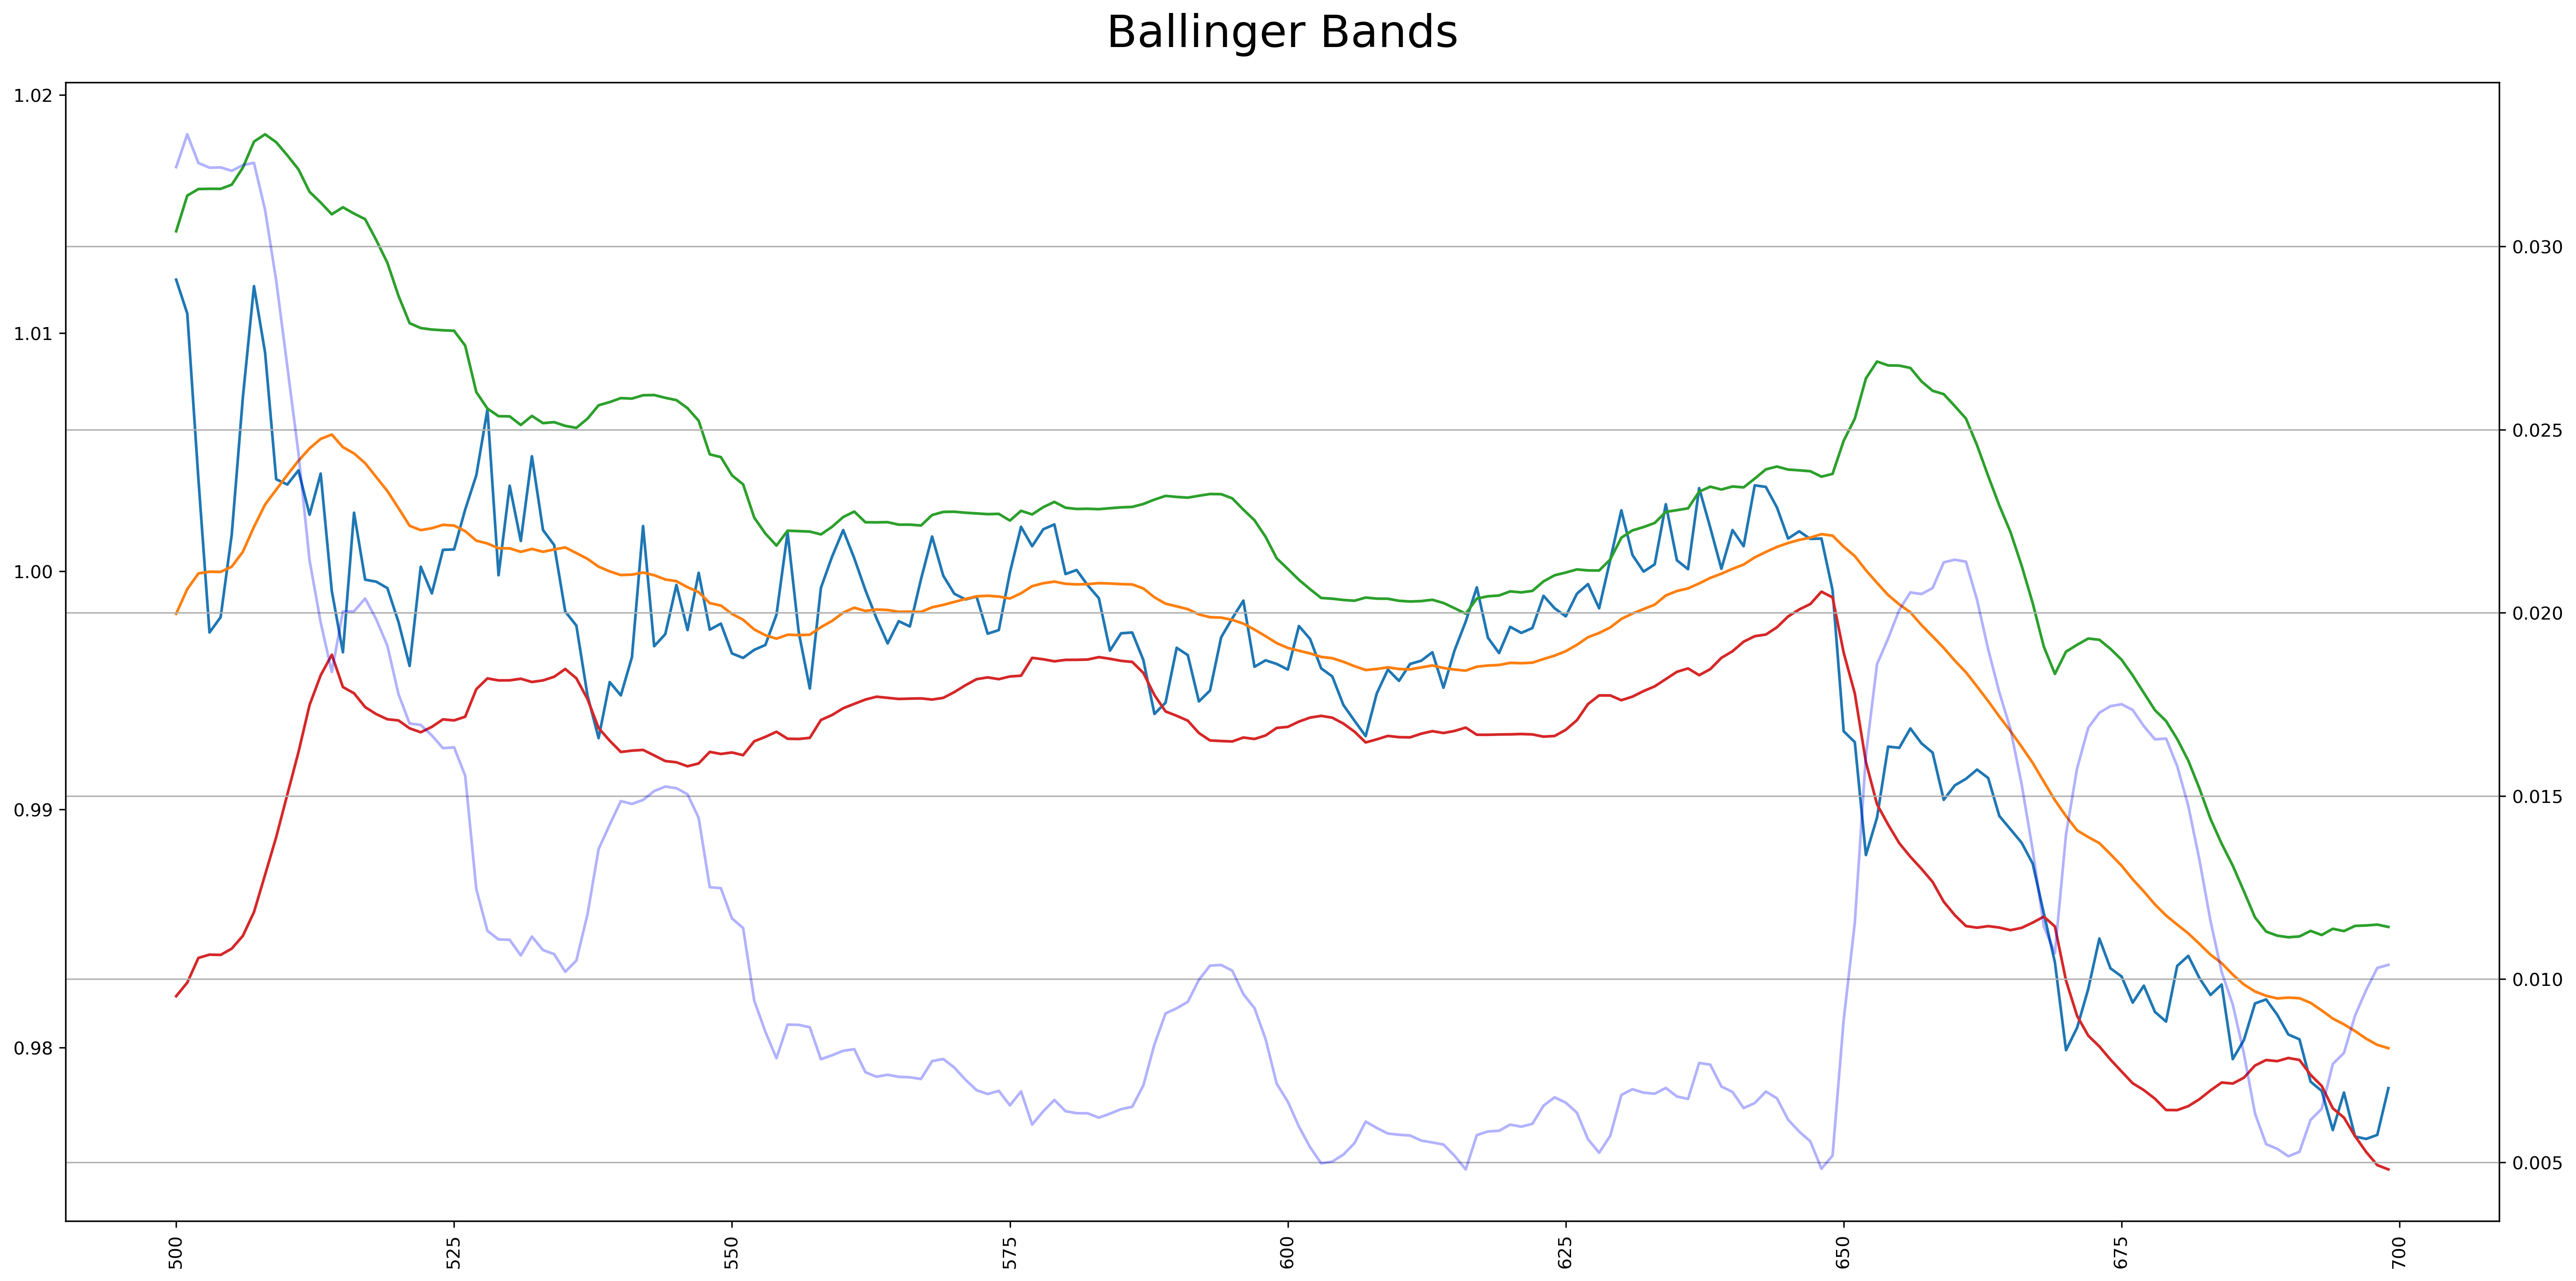

In [35]:
w = 20
h = 10

start_p = 500
end_p = 700

# fig = plt.figure(dpi=300)
fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

plt.title('Ballinger Bands',fontsize = 25,pad=20)
# ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

ax1.plot(temp_df[start_p:end_p][['time']], temp_df[start_p:end_p][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# plt.legend(loc=0)

plt.grid()
plt.xticks(rotation=90)

# ax.axes.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(temp_df[start_p:end_p][['time']],temp_df[start_p:end_p][['ballin_width']], 'b', alpha=0.3)
# ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# ax2.axes.xaxis.set_ticks([])

# ax2.axhline(y=6,linewidth=1, color='r')
# ax2.axhline(y=7,linewidth=1, color='r')
plt.tight_layout()
plt.savefig('./results/strategy3')
plt.show()

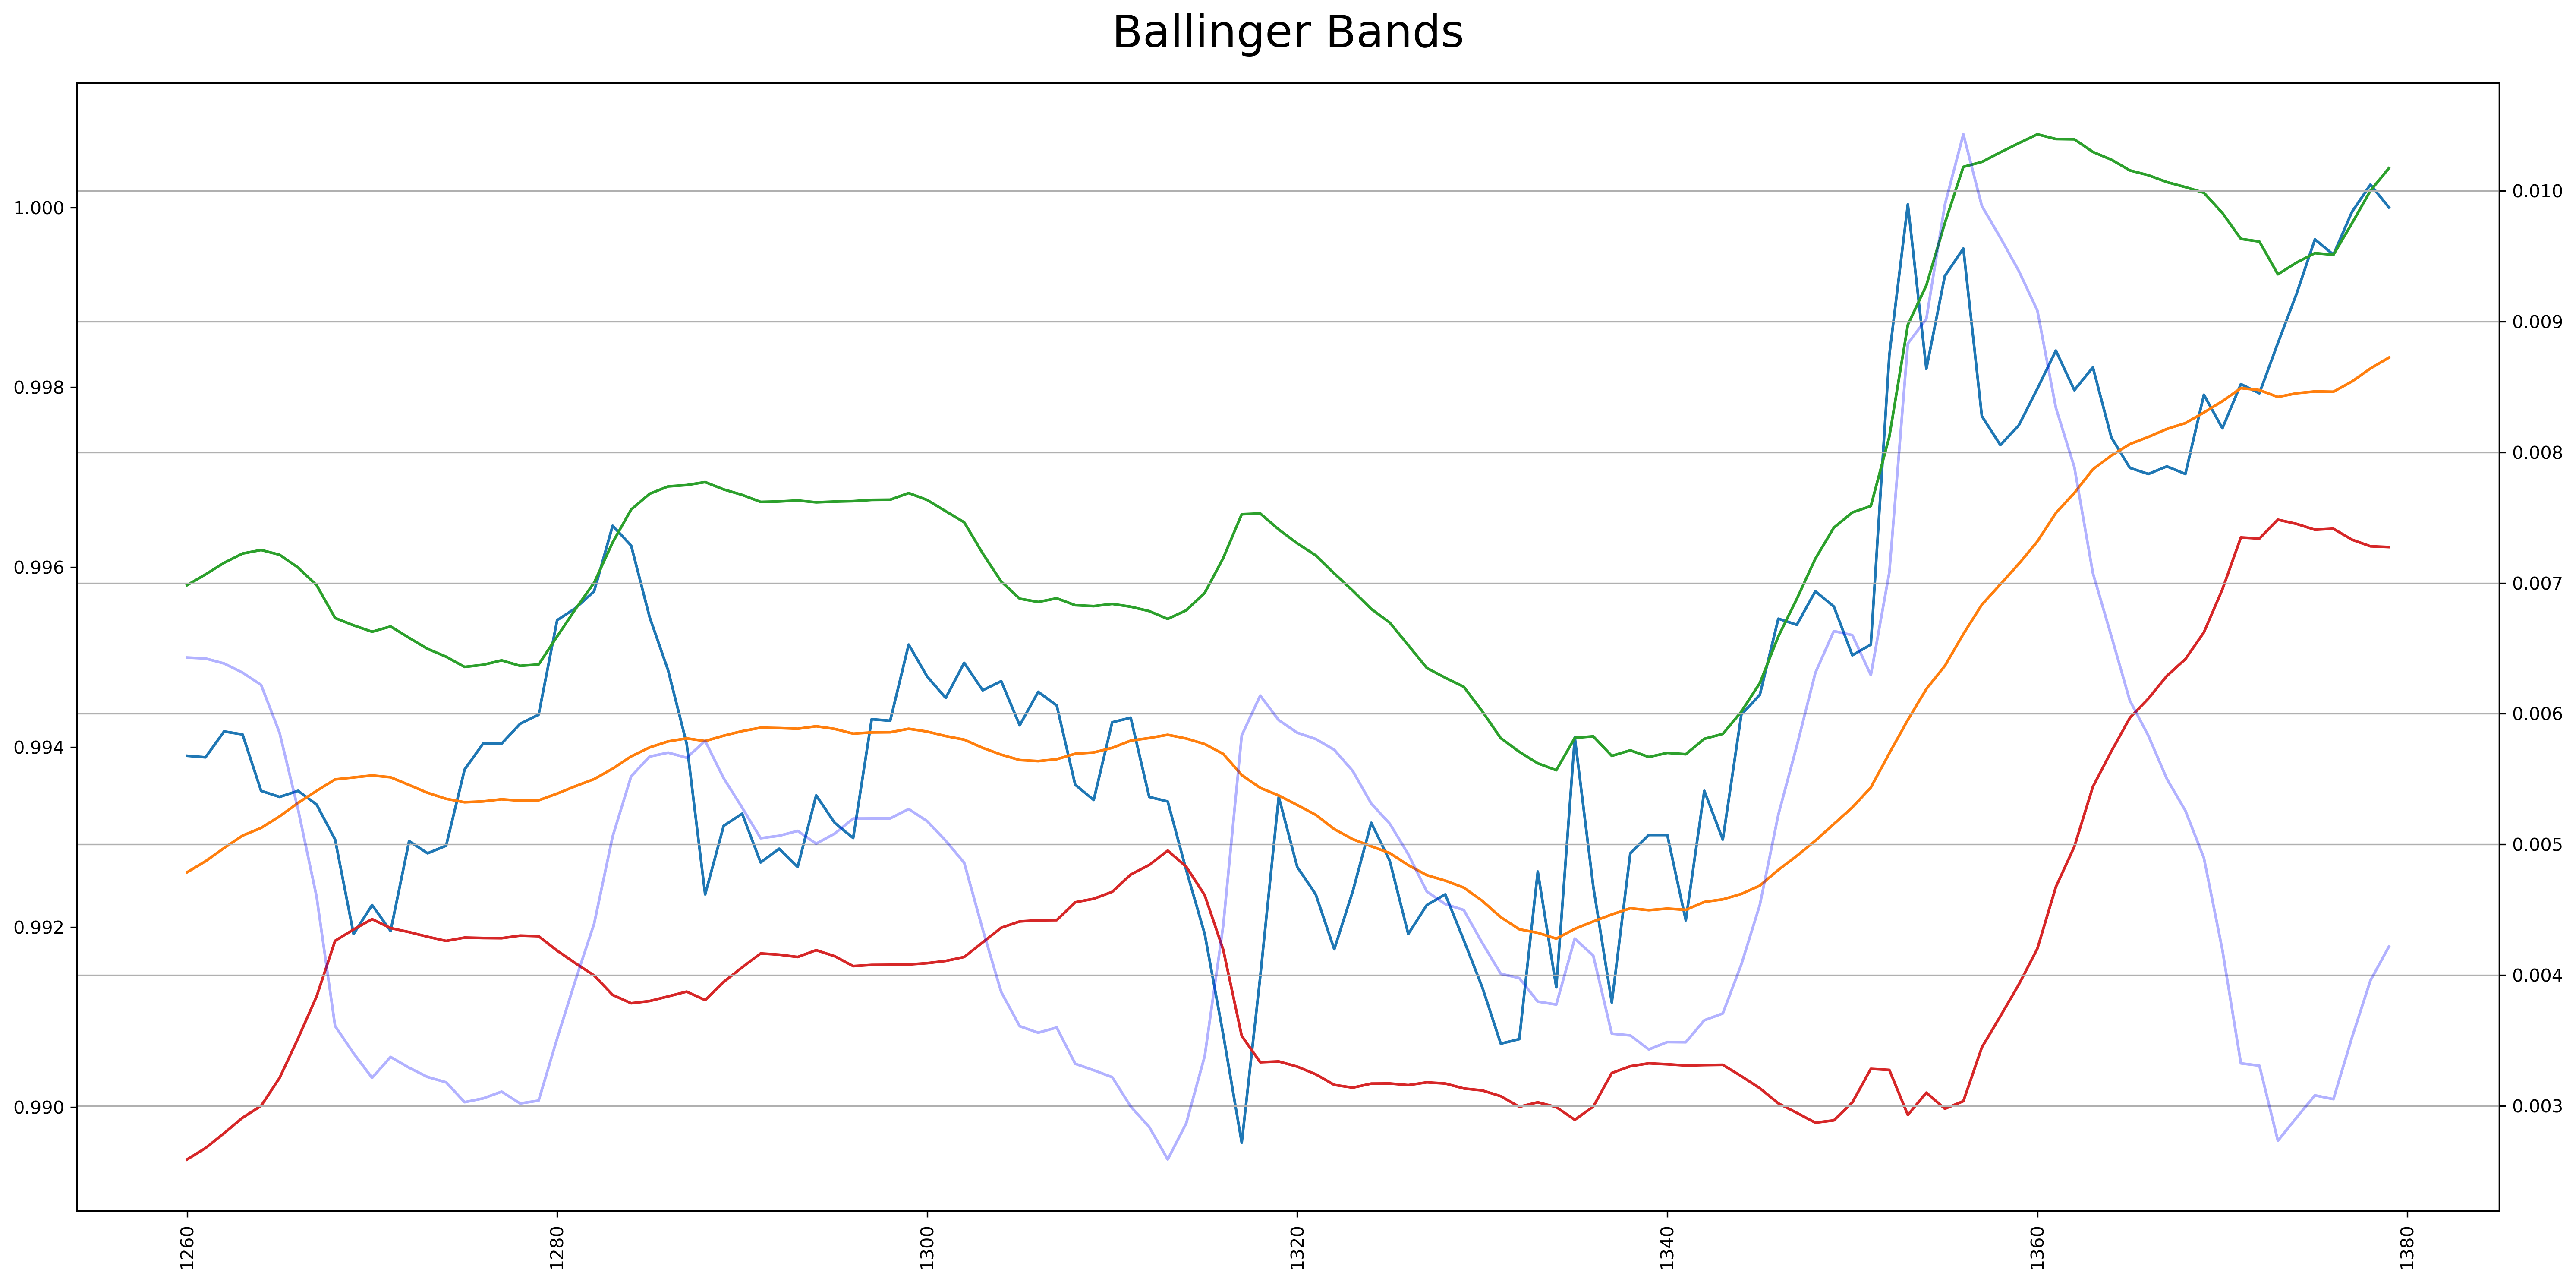

In [20]:
w = 20
h = 10
# fig = plt.figure(dpi=300)
fig, ax1 = plt.subplots(figsize=(w, h), dpi=300)

plt.title('Ballinger Bands',fontsize = 25,pad=20)
# ax = temp_df[1:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot(kind='line')

ax1.plot(temp_df[-120:][['time']], temp_df[-120:][['open', 'mildde_ballin','upper_ballin', 'lower_ballin']])
# plt.legend(loc=0)

plt.grid()
plt.xticks(rotation=90)

# ax.axes.xaxis.set_ticks([])

ax2 = ax1.twinx()
ax2.plot(temp_df[-120:][['time']],temp_df[-120:][['ballin_width']], 'b', alpha=0.3)
# ax2 = temp_df[1:][['ballin_width']].plot(kind='bar',ax=ax1, alpha=0.2, color='blue')
# ax2.axes.xaxis.set_ticks([])

# ax2.axhline(y=6,linewidth=1, color='r')
# ax2.axhline(y=7,linewidth=1, color='r')
plt.tight_layout()
plt.show()

In [18]:
result = []

for sample_id in tqdm(TEST_SAMPLE_ID_LIST):

    # 1. 데이터 로드
    # 1) diff - 학습에 사용
    diff_x = get_diff(test_x, sample_id)

    # 2) vwap - 보조 지표로 사용
    vwap_series = get_vwap(test_x, sample_id)

    # 3) rsi - 보조 지표로 사용
    rsi_series = get_rsi(test_x, sample_id)



    # 2. ARIMA
    # 1) 모델 정의
    ARIMA_MODEL = {}
    ARIMA_MODEL_FIT = {}

    # 2) AR 모델 적용
    try:
      ARIMA_MODEL = ARIMA(diff_x, order = (4,0,1))
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 3) 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
    except:
      ARIMA_MODEL = ARIMA(diff_x, order = (1,1,0))
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 4) ARIMA 예측
    ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')



    # 3. 데이처 처리
    # 1) 최대 부분인 인덱스를 찾는데 해당 시점에 매도를 진행합니다.
    sell_time = np.argmax(ARIMA_FORECAST)

    # 2) 최대값을 찾습니다.
    max_val = np.max(ARIMA_FORECAST)
    
    # 3) vwap의 마지막 값을 가져옵니다.
    vwap_last_val = vwap_series[1379]
    rsi_last_val = rsi_series[1379]



    # 4. 투자 전략
    buy_quantity = 0

    # 1) 최대값이 0 보다 크면 가격이 vwap 보다 크다는 의미로, 투자합니다.
    if  max_val > 0:
        buy_quantity = 1
'''
  #  ------------------------------------------------------------------------------------------
  # 매도 조건에 볼린저 제약 추가할 것임 -->민교 
  # 예를들면 np.argmax(ARIMA_FORECAST) 가 볼밴 상단이탈시 매도 
  #  ---------
'''

    # 2) 만약 vwap 마지막 값이, 1보다 크면 가격이 1보다 작다는 의미로 하향세이기 때문에 투자하지 않습니다.
    if vwap_last_val > 1 and sell_time < 50:
        buy_quantity = 0

'''
 #  ------------------------------------------------------------------------------------------
    # 3) 만약 rsi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
# 07.05 22:29 ris 값이 75 보다 크면 초과매수로 판단하도록 수정 (변동성 최대한 투입)
# 07.11 RSI 상단 터치후 sell time rest 기간이 50분 인데 이게 적절한 것일지 의문
'''
    # 3) 만약 rsi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
    if rsi_last_val > 75 and sell_time < 50:
        buy_quantity = 0



    # 5. 결과
    result_list = [
                   sample_id,
                   buy_quantity,
                   sell_time
                  ]

    result.append(result_list)
    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: 

# 8. 제출 🎉

In [19]:
# 1. 학습 결과를 데이터 프레임으로 만듭니다.

submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]


submit = pd.DataFrame(data=result, columns=submit_columns)


In [76]:
for x in grouped_data:
    # get one sample_id in sample list
    grouped_df.get_group(temp_sample_id)
    break

NameError: name 'grouped_df' is not defined

In [20]:
# 2. 결과 데이터 프레임 확인

submit.head(10)


,sample_id,buy_quantity,sell_time
0,7661,0,47
1,7662,1,62
2,7663,0,11
3,7664,0,48
4,7665,1,46
5,7666,1,70
6,7667,1,119
7,7668,1,82
8,7669,1,109
9,7670,1,66


In [96]:
temp_data.columns

Index(['sample_id', 'time', 'coin_index', 'open', 'high', 'low', 'close',
       'volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av',
       'volume_tb_base_av', 'volume_price', 'volume_price_sum', 'volume_sum',
       'vwap', 'diff', 'U', 'D', 'AU', 'AD', 'rsi', 'mildde_ballin',
       'upper_ballin', 'lower_ballin'],
      dtype='object')

In [21]:
# 3. 투자 개수 확인

submit[submit["buy_quantity"] == 1].shape[0]


420

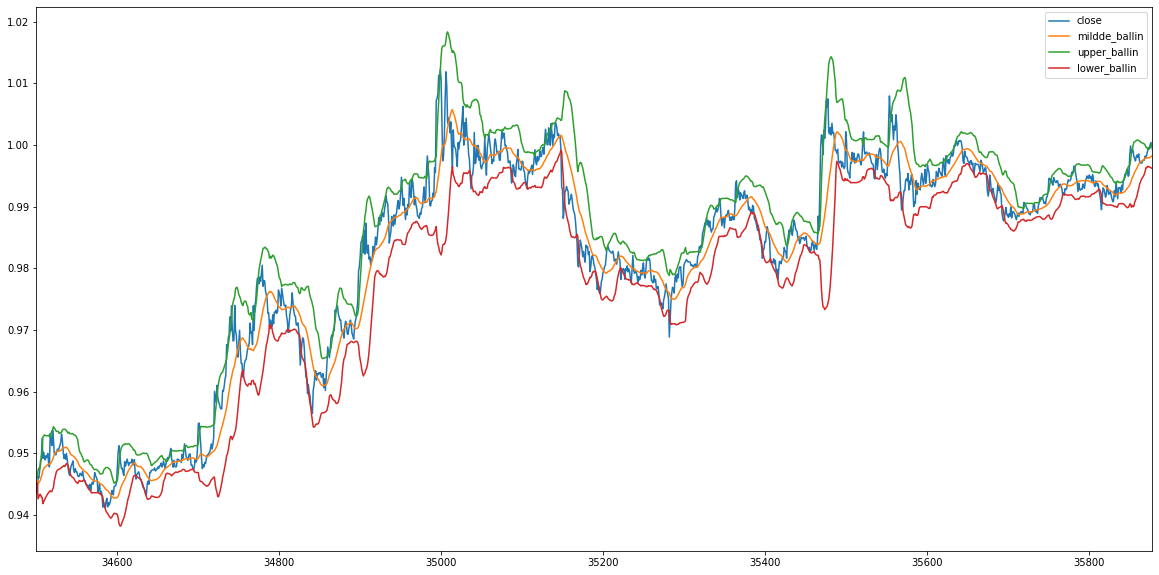

In [118]:
# f = plt.figure(figsize=(20, 10))
f = temp_data[temp_data['sample_id'] == 7954][['close', 'mildde_ballin','upper_ballin', 'lower_ballin']].plot()
plt.show()

In [22]:
# 4. sell_time 50미만에서 구매하는 개수 확인
cond1 = (submit["buy_quantity"] == 1)
cond2 = (submit["sell_time"] < 50)

submit[cond1 & cond2].shape[0]


84

In [23]:
# 5. 제출

In [23]:
temp_data = test_x["open"]

In [24]:
# 파일의 이름을 지정해줍니다.
FILE_NAME = "/0603_ARIMA_DIFF_VWAP_RSI_65_UNDER_50_SUBMIT.csv"


In [40]:
temp_data

0          0.941549
1          0.941586
2          0.941270
3          0.940971
4          0.940077
             ...   
1048795    1.005905
1048796    1.006243
1048797    1.004608
1048798    1.002865
1048799    1.000000
Name: open, Length: 1048800, dtype: float64

In [52]:
grouped_data = temp_data.groupby(['sample_id'])

In [25]:
# 제출경로에 파일을 생성해줍니다.
RESULT_PATH = SUBMIT_PATH + FILE_NAME

submit.to_csv(RESULT_PATH, index=False)


(7929,       sample_id  time  coin_index      open      high       low     close  \
0          7929     0           1  0.941549  0.941773  0.940431  0.941176   
1          7929     1           1  0.941586  0.941736  0.940282  0.940897   
2          7929     2           1  0.941270  0.941586  0.938940  0.940934   
3          7929     3           1  0.940971  0.941363  0.939052  0.940319   
4          7929     4           1  0.940077  0.940561  0.939760  0.939909   
...         ...   ...         ...       ...       ...       ...       ...   
1375       7929  1375           1  1.001305  1.001789  0.999534  0.999758   
1376       7929  1376           1  0.999478  0.999478  0.998136  0.998714   
1377       7929  1377           1  0.998900  0.999161  0.998136  0.999105   
1378       7929  1378           1  0.999124  1.000261  0.999124  1.000112   
1379       7929  1379           1  1.000000  1.000298  0.999236  0.999404   

        volume    quote_av    trades  ...  volume_price  volume_pric

TypeError: tuple indices must be integers or slices, not str

# 9. 안정적 모델인지 어떻게 확인? 🤔
시즌 1을 경험하고, 최대한 안정적인 모델을 생성하기 위해 노력했습니다. 

다만, 내가 안정적이라고 생각해도, 객관적인 지표가 없다보니 얼마나 균형잡혀있는지 확인하기가 어려웠습니다.

이를 위해 public score를 다음과 같이 활용했습니다.

<br>

예를 들어, 
- open에 vwap을 섞어 투자개수가 줄었음에도 점수가 올라가는 현상
- vwap, rsi등 보조지표를 통해 sell_time 10, 20.. 50 미만은 투자하지 않기로 결정했음에도 점점 점수가 올라가는 현상
- rsi 초과매수로 상태를 70 초과가 아닌, 65 초과로, 더 안정적으로 결정해도 점수가 상승하는 현상
<br>

이렇게, 제약사항을 통해 보수적으로 투자했음에도 불구하고, 점수가 올라가는 경우에 집중하여, 해당 피쳐가 안정적으로 작용함을 판단했습니다.


In [31]:
temp_data[:20]

0     0.941549
1     0.941586
2     0.941270
3     0.940971
4     0.940077
5     0.940189
6     0.941400
7     0.941885
8     0.941810
9     0.941885
10    0.939779
11    0.941307
12    0.940487
13    0.941586
14    0.941754
15    0.939089
16    0.939238
17    0.939704
18    0.940151
19    0.939723
Name: open, dtype: float64

In [36]:
temp_data.rolling(20, min_periods=1).mean()[:20]

0     0.941549
1     0.941568
2     0.941468
3     0.941344
4     0.941091
5     0.940940
6     0.941006
7     0.941116
8     0.941193
9     0.941262
10    0.941127
11    0.941142
12    0.941092
13    0.941127
14    0.941169
15    0.941039
16    0.940933
17    0.940865
18    0.940827
19    0.940772
Name: open, dtype: float64

In [30]:
temp_data[:20].mean()

0.9407719761133194

In [ ]:
def BBands(df_close, w=20, k=2):
    """
        w: 이동평균선 기간 값 (20)
        k: 승수 (2)
    """
    # 고가, 저가, 종가의 평균을 이용하는 경우 정수로 변환이 필요
    df_close = df_close.astype(int)
    # 표준편차
    std = df_close[:w].std()[0]
    # mean() 함수는 '평균을 구하기 위한' numpy 패키지에 포함되어 있는 내장 함수입니다.
    # 20일 이평선이자 볼린저밴드 중앙선
    mbb = df_close[:w].mean()[0]
    # 종가
    close = df_close[0][0]

    '''
        std (표준편차 값)과 mbb(중앙선)을 이용하여 볼린저밴드
        1. ubb (상한선)
        2. lbb (하한선)
        3. perb (%b: 볼린저밴드에서의 종가 위치)
        4. bw (밴드폭)
        4개의 값을 구하는 수식을 01)볼린저밴드 개념에 안내되어 있는 [볼린저 밴드 계산방법]을 참고하여 구현해주세요.
        변수 이름은 ubb, lbb, perb, bw로 통일하여 주시기 바랍니다.
    '''

    # 볼린저밴드 상한선과 하한선 수치 구하는 식
    ### blank ###########################
    # ubb =
    # lbb =
    #####################################

    if ubb > lbb:
        ### blank ###########################
        # perb =
        # bw =
        #####################################
        return mbb, ubb, lbb, perb, bw
    else:
        return False

# 10. 여러 아이디어 🥴
65번이라는 조금 많은 제출을 통해 여러 시도를 진행했습니다. 저의 개인적인 결과는 좋지 않았습니다만, 혹시나 이후 대회에서 다른 분들에게 조금이라도 도움이 될 수 있을까 해서 남기게 되었습니다.

<br>

### 1) RANDOM BOX 분류 모델
시계열 대회이지만, classification으로 생각해보았습니다.

결국에 제가 선택하는것은 120개중 1개이기 때문에 120개의 상자 중 1개를 선택했을때 그 값이 1보다 클 확률을 제가 얻을 수 있는 기대값이라고 생각했습니다. 

개인적으로 가장 창의적이라고 생각했지만, 잘 안되었습니다. 더 지니어스의 콩픈패스에 영감을 받았습니다.


<br>

### 2) 혼합 데이터
open에 vwap을 섞은것에 더하여, RSI, 이동평균선등을 모두 섞어 보았습니다. 생각보다 점수가 정말 좋았지만, vwap 한개를 섞은것보다는 아쉽다고 생각하여 사용하지는 않았습니다.

<br>



# 11. 다른 모델 사용여부 😁
ARIMA 이외에도 prophet, neural prophet, LSTM등 다양한 모델을 사용해보았습니다. 

다만, 더 좋은 결과를 주지 않았다고 판단했습니다.

또한, 위 모델들의 결과를 bagging하는 방법을 사용해보았지만, ARIMA 단 하나만을 사용했을때보다 예측 성능이 낮아진다고 판단하여 사용하지 않게 되었습니다.



# 7. 모델 학습 🤑